<a href="https://colab.research.google.com/github/sivani-tutika/LLM-Growth-Training/blob/main/When_to_grow_shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing Best models of pre-trained methods

Comperative Survey:

Wiki - 2

| Model | Category | Validation Loss | Training FLOPs | Memory | Time |
|-|-|-|-|-|-|
|Stacking|-|-|-|-|-|
|LiGO Depth only|-|-|-|-|-|
|CrossLiGO depth only|-|-|-|-|-|
|StackLiGO depth only|-|-|-|-|-|


Wiki - 103

| Model | Category | Validation Loss | Training FLOPs | Memory | Time |
|-|-|-|-|-|-|
|Stacking|-|-|-|-|-|
|LiGO Depth only|-|-|-|-|-|
|CrossLiGO depth only|-|-|-|-|-|
|StackLiGO depth only|-|-|-|-|-|


Shakespeare

| Model | Category | Validation Loss | Training FLOPs | Memory | Time |
|-|-|-|-|-|-|
|Stacking|-|-|-|-|-|
|LiGO Depth only|-|-|-|-|-|
|CrossLiGO depth only|-|-|-|-|-|
|StackLiGO depth only|-|-|-|-|-|


---

"When to grow policy"

Wiki-2

| Model | Category | Validation Loss | Training FLOPs | Memory | Time |
|-|-|-|-|-|-|
|Periodic|-|-|-|-|-|
|Convergence|-|-|-|-|-|
|LipGrow|-|-|-|-|-|
|FRAWGrow|-|-|-|-|-|

Wiki-103

| Model | Category | Validation Loss | Training FLOPs | Memory | Time |
|-|-|-|-|-|-|
|Periodic|-|-|-|-|-|
|Convergence|-|-|-|-|-|
|LipGrow|-|-|-|-|-|
|FRAWGrow|-|-|-|-|-|

Shakespeare

| Model | Category | Validation Loss | Training FLOPs | Memory | Time |
|-|-|-|-|-|-|
|Periodic|-|-|-|-|-|
|Convergence|-|-|-|-|-|
|LipGrow|-|-|-|-|-|
|FRAWGrow|-|-|-|-|-|

# Libraries

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
   ---------------------------------------- 0.0/6.1 MB ? eta -:--:--
   ---------------------------------------- 6.1/6.1 MB 31.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 GB 124.1 MB/s eta 0:00:20
    --------------------------------------- 0.0/2.5 GB 122.0 MB/s eta 0:00:21
   - -------------------------------------- 0.1/2.5 GB 120.0 MB/s eta 0:00:21
   - -------------------------------------- 0.1/2.5 GB 119.7 MB/s eta 0:00:21
   - -------------------------------------- 0.1/2.5 GB 118.5 MB/s eta 0:00:21
   -- ------------------------------------- 0.1/2.5 GB 114.6 MB/s eta 0:00:21
   -- ------------------------------------- 0.2/2.5 GB 113.0 MB/s eta 0:00:21
   -- ------------------------------------- 0.2/2.5 GB 112.8 MB/s eta 0:00:21
   --- ------------------------------------ 0.2/2.5 GB 111.0 MB/s eta 0:00:21
   --- -----------------

In [1]:
!pip install pytorch
!pip install transformers
!pip install datasets
!pip install calflops
!pip install matplotlib

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pytorch)


In [2]:
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling
from datasets import load_dataset
from calflops import calculate_flops
import matplotlib.pyplot as plt
import time

# Settings

In [3]:
# LiGO_bool = True
# emb_size = 256
# new_emb_size = 512
# block_size = 128
# multi_heads = 2
# batch_size = 16
# epochs = 3
# learning_rate = 3e-4
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# num_small_layers = 4
# multi_heads = 2
# num_large_layers = 8



# Datasets

## Shakespeare

In [4]:
import torch

path = '/kaggle/input/shakespeare-dataset/shakespeare_dat.txt'
# Load and process Shakespeare dataset
with open(path, 'r') as f:
    dat = f.read()

chars = sorted(list(set(dat)))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda i: ''.join([itos[l] for l in i])

# Convert text to tensor
data = torch.tensor(encode(dat))

# Train-test split (90% train, 10% validation)
n = int(0.9 * len(data))
shakespeare_train = data[:n]
shakespeare_val = data[n:]


In [5]:

# Hyperparameters
LiGO_bool = True
block_size = 8
batch_size = 2048
val_batch_size = 2048
vocab_size = len(chars)
emb_size = 32
new_emb_size = 64
num_small_layers = 4
multi_heads = 2
num_large_layers = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     

In [6]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# import numpy as np

# # Load Shakespeare text from file
# with open('/content/shakespeare_dat.txt', 'r') as f:
#     dat = f.read()

# # Character mappings
# chars = sorted(list(set(dat)))
# stoi = {ch: i for i, ch in enumerate(chars)}
# itos = {i: ch for i, ch in enumerate(chars)}
# encode = lambda s: [stoi[c] for c in s]  # Convert text to integer list
# decode = lambda i: ''.join([itos[l] for l in i])  # Convert int list to text


# # Hyperparameters (Global)
# block_size = 8
# batch_size = 2048
# val_batch_size = 2048
# vocab_size = len(chars)
# train_frac = 0.9  # Fraction for train-validation split


# # Convert text data to tensor
# data = torch.tensor(encode(dat), dtype=torch.long)

# # Shuffle and Split Dataset
# def shuffle_and_split(data, train_frac=0.9):
#     n = int(train_frac * len(data))  # Split point
#     indices = torch.randperm(len(data)).tolist()  # Shuffle indices
#     train_data = data[indices[:n]]
#     val_data = data[indices[n:]]
#     return train_data, val_data

# # Shuffle and split data
# train_data, val_data = shuffle_and_split(data)

# # Define a PyTorch Dataset
# class ShakespeareDataset(Dataset):
#     def __init__(self, data, block_size):
#         self.data = data
#         self.block_size = block_size

#     def __len__(self):
#         return len(self.data) - self.block_size

#     def __getitem__(self, idx):
#         x = self.data[idx:idx + self.block_size]
#         y = self.data[idx + 1:idx + self.block_size + 1]
#         return x, y

# # Create DataLoader objects with custom variable names
# shakespeare_train_dataset = ShakespeareDataset(train_data, block_size)
# shakespeare_val_dataset = ShakespeareDataset(val_data, block_size)

# shakespeare_train_loader = DataLoader(shakespeare_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# shakespeare_val_loader = DataLoader(shakespeare_val_dataset, batch_size=val_batch_size, shuffle=False, drop_last=True)


# Transformer Architecture

In [7]:
# LiGO_bool = True
# emb_size = 256
# new_emb_size = 512
# block_size = 128
# multi_heads = 2
# batch_size = 16
# epochs = 3
# learning_rate = 3e-4
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# num_small_layers = 4
# multi_heads = 2
# num_large_layers = 8

## Basic blocks

In [8]:
class AttentionHead(torch.nn.Module):
    def __init__(self, big=False):
        super(AttentionHead, self).__init__()
        self.k = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.q = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.v = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
    def forward(self, e):
        keys = self.k(e)
        queries = self.q(e)
        values = self.v(e)
        ret = keys @ queries.transpose(1, 2)*(1.0/math.sqrt(keys.size(-1)))
        ret = torch.masked_fill(ret, self.tril==0, -torch.inf)
        ret = torch.softmax(ret, 2)
        ret = ret @ values
        return ret

In [9]:
class MultiHead(torch.nn.Module):
    def __init__(self, big=False):
        super(MultiHead, self).__init__()
        self.head1 = AttentionHead(big)
        self.head2 = AttentionHead(big)
        self.mh_lin = torch.nn.Linear(multi_heads*(new_emb_size if big else emb_size), new_emb_size if big else emb_size, bias=False)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        x1 = self.head1(inp)
        x2 = self.head2(inp)
        return self.mh_lin(self.drop(torch.cat([x1,x2], dim=2))).relu()

In [10]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [11]:
class Block(torch.nn.Module):
    def __init__(self, big=False):
        super(Block, self).__init__()
        self.multihead = MultiHead(big)
        self.l_norm_1 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.l_norm_2 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.ffn = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        m = self.l_norm_1(inp + self.multihead(inp))
        m = self.l_norm_2(m + self.ffn(self.drop(m)).relu())
        return m

# Train & Validation


## Static methods

In [12]:
# loss_fn = torch.nn.CrossEntropyLoss()

# @torch.no_grad()
# def validate(mdl, dataloader):
#     mdl.to(device)
#     mdl.eval()
#     total_loss = 0
#     num_batches = 0

#     torch.cuda.reset_peak_memory_stats(device)  # Reset memory stats

#     start_time = time.time()
#     for batch in dataloader:
#         inputs = batch["input_ids"].squeeze(1).to(device)
#         outputs = mdl(inputs)
#         loss = loss_fn(outputs.view(-1, vocab_size), inputs.view(-1))
#         total_loss += loss.item()
#         num_batches += 1

#     val_time = time.time() - start_time
#     max_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

#     print(f"Validation Time: {val_time:.2f}s, Max Memory Usage: {max_memory:.2f} MB")

#     return total_loss / num_batches


# import torch
# import time
# import psutil

# def get_cpu_memory():
#     """Returns current CPU memory usage in MB."""
#     process = psutil.Process()
#     return process.memory_info().rss / (1024 ** 2)  # Convert bytes to MB

# def train(mdl, optim, epochs, train_dataloader, val_dataloader):
#     mdl.to(device)

#     train_losses_epoch = []
#     val_losses_epoch = []

#     train_times = []   # Training time per epoch
#     val_times = []     # Validation time per epoch
#     gpu_memory_usage = []  # GPU memory per epoch
#     cpu_memory_usage = []  # CPU memory per epoch
#     flops_per_epoch = []   # FLOPs per epoch

#     for epoch in range(epochs):
#         start_time = time.time()
#         mdl.train()
#         total_loss = 0
#         num_batches = 0
#         total_flops = 0  # Track FLOPs for this epoch

#         torch.cuda.reset_peak_memory_stats(device)  # Reset GPU memory tracking

#         for batch in train_dataloader:
#             inputs = batch["input_ids"].squeeze(1).to(device)
#             optim.zero_grad()
#             outputs = mdl(inputs).to(device)
#             loss = loss_fn(outputs.view(-1, vocab_size), inputs.view(-1))
#             loss.backward()
#             optim.step()

#             total_loss += loss.item()
#             num_batches += 1

#             # Compute FLOPs for this batch
#             flops, _, _ = calculate_flops(model=mdl.to(device), kwargs={'inp': inputs},
#                                           print_detailed=False, print_results=False, output_as_string=False)
#             total_flops += flops  # Accumulate FLOPs

#             if num_batches % 100 == 0:
#                 print(f"{num_batches} processed")

#         train_time = time.time() - start_time  # Epoch training time
#         train_times.append(train_time)

#         # Store memory usage
#         max_gpu_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # MB
#         max_cpu_memory = get_cpu_memory()  # MB

#         # gpu_memory_usage.append(max_gpu_memory)
#         cpu_memory_usage.append(max_cpu_memory)

#         avg_loss = total_loss / num_batches
#         train_losses_epoch.append(avg_loss)

#         # Validate model and track validation time + memory usage
#         val_start_time = time.time()
#         val_loss, _ = validate(mdl, val_dataloader)
#         val_time = time.time() - val_start_time
#         val_times.append(val_time)

#         val_losses_epoch.append(val_loss)

#         # Convert FLOPs to TFLOPs (TeraFLOPs)
#         flops_per_epoch.append(total_flops / 1e12)

#         print(f"Epoch {epoch+1}: Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, "
#               f"Train Time: {train_time:.2f}s, Val Time: {val_time:.2f}s, "
#               f"GPU Memory: MB, CPU Memory: {max_cpu_memory:.2f} MB, "
#               f"TFLOPs: {total_flops / 1e12:.4f}")

#     return {
#         "train_losses": train_losses_epoch,
#         "val_losses": val_losses_epoch,
#         "train_times": train_times,
#         "val_times": val_times,
#         "gpu_memory": gpu_memory_usage,
#         "cpu_memory": cpu_memory_usage,
#         "flops": flops_per_epoch  # Returning FLOPs per epoch
#     }


In [13]:
# @torch.no_grad()
# def validate(mdl, dataloader):
#     mdl.eval()
#     total_loss = 0
#     num_batches = 0
#     val_losses = []
#     for batch in dataloader:
#         inputs = batch["input_ids"].squeeze(1).to(device)
#         outputs = mdl(inputs)
#         loss = loss_fn(outputs.view(-1, vocab_size), inputs.view(-1))
#         total_loss += loss.item()
#         num_batches += 1
#         if num_batches % 100 == 0:
#             val_losses.append(total_loss / num_batches)
#     return total_loss / num_batches, val_losses

# @torch.enable_grad()
# def train(mdl, optim, epochs, train_dataloader, val_dataloader):
#     # mdl.to(device)
#     train_losses = []
#     val_losses_epoch = []
#     for epoch in range(epochs):
#         mdl.train()
#         total_loss = 0
#         num_batches = 0
#         for batch in train_dataloader:
#             inputs = batch["input_ids"].squeeze(1).to(device)
#             optim.zero_grad()
#             outputs = mdl(inputs)
#             loss = loss_fn(outputs.view(-1, vocab_size), inputs.view(-1))
#             loss.backward()
#             optim.step()
#             total_loss += loss.item()
#             num_batches += 1
#             if num_batches % 100 == 0:
#                 train_losses.append(total_loss / num_batches)

#         avg_loss = total_loss / num_batches
#         val_loss, val_losses = validate(mdl, val_dataloader)
#         val_losses_epoch.extend(val_losses)
#         print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")

#     return train_losses, val_losses_epoch

In [14]:
loss = torch.nn.CrossEntropyLoss()
torch.manual_seed(1337)
def get_batch(split):
    data = shakespeare_train if split == 'train' else shakespeare_val
    ix = torch.randint(len(data) - block_size, (batch_size if split=='train' else val_batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

@torch.no_grad()
def validate(mdl):
    mdl.eval()
    vx, vy = get_batch('val')
    out = mdl(vx.to(device))
    return loss(out.view(-1, 65), vy.view(-1).to(device)).item()


@torch.enable_grad()
def train(mdl, optim, epochs):
    ind = 0
    train_curve = []
    total_flops = 0
    flops_per_epoch = []
    train_loss_per_epoch = []
    val_loss_per_epoch = []

    for _ in range(epochs):
        mdl.train()
        optim.zero_grad()
        x, y = get_batch('train')
        out = mdl(x.to(device))
        l = loss(out.view(-1, 65), y.view(-1).to(device))
        l.backward()
        optim.step()
        ind += 1

        train_loss_per_epoch.append(l.item())

        flops, macs, params = calculate_flops(model=mdl, kwargs={'inp': x.to(device)}, print_detailed=False, print_results=False, output_as_string=False)
        total_flops += flops
        flops_per_epoch.append(total_flops)
        v = validate(mdl)
        val_loss_per_epoch.append(v)

        # if ind%10 == 0:
        #     v = validate(mdl)
        #     if ind%100==0:
        #         print(l.item())
        #         print(f"Validation: {v}")
        #     train_curve.append(v)


    return {
        "train_losses": train_loss_per_epoch,
        "val_losses": val_loss_per_epoch,
        "flops": flops_per_epoch
    }


## Periodic methods

In [15]:
# loss = torch.nn.CrossEntropyLoss()
# torch.manual_seed(1337)
# def periodic_get_batch(split):
#     data = shakespeare_train if split == 'train' else shakespeare_val
#     ix = torch.randint(len(data) - block_size, (batch_size if split=='train' else val_batch_size,))
#     x = torch.stack([data[i:i+block_size] for i in ix])
#     y = torch.stack([data[i+1:i+block_size+1] for i in ix])
#     return x, y

# @torch.no_grad()
# def periodic_validate(mdl):
#     mdl.eval()
#     vx, vy = periodic_get_batch('val')
#     out = mdl(vx.to(device))
#     return loss(out.view(-1, 65), vy.view(-1).to(device)).item()


# @torch.enable_grad()
# def periodic_train(mdl, optim, epochs):
#     ind = 0
#     train_curve = []
#     total_flops = 0
#     flops_per_epoch = []
#     train_loss_per_epoch = []
#     val_loss_per_epoch = []

#     for _ in range(epochs):


        
#         mdl.train()
#         optim.zero_grad()
#         x, y = periodic_get_batch('train')
#         out = mdl(x.to(device))
#         l = loss(out.view(-1, 65), y.view(-1).to(device))
#         l.backward()
#         optim.step()
#         ind += 1

#         train_loss_per_epoch.append(l.item())

#         flops, macs, params = calculate_flops(model=mdl, kwargs={'inp': x.to(device)}, print_detailed=False, print_results=False, output_as_string=False)
#         total_flops += flops
#         flops_per_epoch.append(total_flops)
#         v = validate(mdl)
#         val_loss_per_epoch.append(v)

#         # if ind%10 == 0:
#         #     v = validate(mdl)
#         #     if ind%100==0:
#         #         print(l.item())
#         #         print(f"Validation: {v}")
#         #     train_curve.append(v)


#     return {
#         "train_losses": train_loss_per_epoch,
#         "val_losses": val_loss_per_epoch,
#         "flops": flops_per_epoch
#     }


In [16]:
import torch.nn as nn
import torch.optim as optim

# Define your loss function
loss = torch.nn.CrossEntropyLoss()
torch.manual_seed(1337)

def periodic_get_batch(split):
    data = shakespeare_train if split == 'train' else shakespeare_val
    ix = torch.randint(len(data) - block_size, (batch_size if split=='train' else val_batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

@torch.no_grad()
def periodic_validate(mdl):
    mdl.eval()
    vx, vy = periodic_get_batch('val')
    out = mdl(vx.to(device))
    return loss(out.view(-1, 65), vy.view(-1).to(device)).item()

@torch.enable_grad()
def periodic_train(mdl, optim, epochs, num_blocks):
    ind = 0
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    flops_per_epoch = []
    total_flops = 0
    mdl.to(device)

    # Determine when to add blocks based on total epochs and number of blocks
    block_intervals = epochs // (num_blocks + 1)

    for epoch in range(epochs):
        
        # Add a new block at the designated intervals
        if epoch > 0 and epoch % block_intervals == 0:
            print(f"Adding new block at epoch {epoch}")
            # old_params = optim.get_params()
            mdl.add_block()  # Assuming 'add_block' method exists in your model
            new_params = list(mdl.blocks[-1].parameters())  # Get new block parameters
            optim.add_param_group({'params': new_params})  # Add new params to optimizer
            print("added successfully")
            mdl.to(device)

        mdl.train()
        optim.zero_grad()
        x, y = periodic_get_batch('train')
        out = mdl(x.to(device))
        l = loss(out.view(-1, 65), y.view(-1).to(device))
        l.backward()
        optim.step()
        ind += 1

        # Store training loss for the current epoch
        train_loss_per_epoch.append(l.item())

        # Compute FLOPs
        flops, macs, params = calculate_flops(model=mdl, kwargs={'inp': x.to(device)}, 
                                              print_detailed=False, print_results=False, output_as_string=False)
        total_flops += flops
        flops_per_epoch.append(total_flops)

        # Compute validation loss
        v = validate(mdl)
        val_loss_per_epoch.append(v)

    # Return all metrics
    return {
        "train_losses": train_loss_per_epoch,
        "val_losses": val_loss_per_epoch,
        "flops": flops_per_epoch
    }


## Convergence methods

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt

loss = torch.nn.CrossEntropyLoss()
torch.manual_seed(1337)

def convergence_get_batch(split):
    data = shakespeare_train if split == 'train' else shakespeare_val
    ix = torch.randint(len(data) - block_size, (batch_size if split=='train' else val_batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

@torch.no_grad()
def convergence_validate(mdl):
    mdl.eval()
    vx, vy = convergence_get_batch('val')
    out = mdl(vx.to(device))
    return loss(out.view(-1, 65), vy.view(-1).to(device)).item()

@torch.enable_grad()
def convergence_train(mdl, optim, epochs, num_blocks=4, patience=5, threshold=1e-3, moving_avg_window=5, stability_threshold=0.002):
    ind = 0
    train_curve = []
    total_flops = 0
    flops_per_epoch = []
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    best_loss = float('inf')
    no_improve_count = 0
    period_interval = epochs // (num_blocks+1)
    new_blocks = 0
    block_added = False
    
    for epoch in range(epochs):
        
        mdl.train()
        optim.zero_grad()
        x, y = convergence_get_batch('train')
        out = mdl(x.to(device))
        l = loss(out.view(-1, 65), y.view(-1).to(device))
        l.backward()
        optim.step()
        ind += 1

        train_loss_per_epoch.append(l.item())
        flops, macs, params = calculate_flops(model=mdl, kwargs={'inp': x.to(device)}, print_detailed=False, print_results=False, output_as_string=False)
        total_flops += flops
        flops_per_epoch.append(total_flops)
        v = convergence_validate(mdl)
        val_loss_per_epoch.append(v)


        if new_blocks < num_blocks:
            
            # Compute moving average
            if len(train_loss_per_epoch) >= moving_avg_window and not block_added:
                moving_avg_losses = np.convolve(train_loss_per_epoch, np.ones(moving_avg_window)/moving_avg_window, mode='valid')
                
                if len(moving_avg_losses) > 1 and abs(moving_avg_losses[-1] - moving_avg_losses[-2]) < stability_threshold and not block_added:
                        print(f"Stable loss detected at epoch {epoch+1}, adding block.")
                        mdl.add_block()  # Assuming 'add_block' method exists in your model
                        new_params = list(mdl.blocks[-1].parameters())  # Get new block parameters
                        optim.add_param_group({'params': new_params})  # Add new params to optimizer
                        print("Added successfully")
                        new_blocks += 1
                        mdl.to(device)
                        block_added = True
            
            # Ensure only one block is added per period interval
            if (epoch + 1) % period_interval == 0:
                

                if not block_added:
                    print(f"Forcing block addition at epoch {epoch+1} due to period interval.")
                    mdl.add_block()  # Assuming 'add_block' method exists in your model
                    new_params = list(mdl.blocks[-1].parameters())  # Get new block parameters
                    optim.add_param_group({'params': new_params})  # Add new params to optimizer
                    print("Added successfully")
                    new_blocks += 1
                    mdl.to(device)
                    
                block_added = False
    
    return {
        "train_losses": train_loss_per_epoch,
        "val_losses": val_loss_per_epoch,
        "flops": flops_per_epoch
    }


## FRAWGrow

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt

loss_fn = torch.nn.CrossEntropyLoss()
torch.manual_seed(1337)

def frawgrow_get_batch(split):
    data = shakespeare_train if split == 'train' else shakespeare_val
    ix = torch.randint(len(data) - block_size, (batch_size if split=='train' else val_batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

@torch.no_grad()
def FRAWGrow_validate(mdl, split):
    mdl.eval()
    vx, vy = frawgrow_get_batch(split)
    out = mdl(vx.to(device))
    return loss_fn(out.view(-1, 65), vy.view(-1).to(device)).item()

@torch.enable_grad()
def FRAWGrow_train(mdl, optim, epochs, num_blocks=4, alpha=1.0, min_fine_tuning_epochs=10):
    ind = 0
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    flops_per_epoch = []
    period_interval = epochs // (num_blocks+1)
    new_blocks = 0
    total_flops = 0
    block_added = False
    
    I_max = epochs - min_fine_tuning_epochs
    
    for epoch in range(epochs):
        mdl.train()
        optim.zero_grad()
        x, y = frawgrow_get_batch('train')
        out = mdl(x.to(device))
        l = loss_fn(out.view(-1, 65), y.view(-1).to(device))
        l.backward()
        optim.step()
        ind += 1

        train_loss = l.item()
        val_loss = FRAWGrow_validate(mdl, 'val')
        train_loss_per_epoch.append(train_loss)
        val_loss_per_epoch.append(val_loss)
        
        # Compute FLOPs
        flops, macs, params = calculate_flops(model=mdl, kwargs={'inp': x.to(device)}, print_detailed=False, print_results=False, output_as_string=False)
        total_flops += flops
        flops_per_epoch.append(total_flops)
        
        # Compute ORL
        ORL = val_loss - train_loss
        I = I_max / (1 + np.exp(alpha - ORL))
        
        if new_blocks < num_blocks:
            # Ensure only one block is added per interval
            if len(train_loss_per_epoch) >= min_fine_tuning_epochs and not block_added:
                if I > 0.5:
                    print(f"Growth condition met at epoch {epoch+1}, adding block.")
                    mdl.add_block()
                    new_params = list(mdl.blocks[-1].parameters())  # Get new block parameters
                    optim.add_param_group({'params': new_params})  # Add new params to optimizer
                    print("Added successfully")
                    new_blocks += 1
                    mdl.to(device)
                    block_added = True
            
            # Ensure at least one block is added per interval
            if (epoch + 1) % period_interval == 0:
                if not block_added:
                    print(f"Forcing block addition at epoch {epoch+1} due to period interval.")
                    mdl.add_block()
                    new_params = list(mdl.blocks[-1].parameters())  # Get new block parameters
                    optim.add_param_group({'params': new_params})  # Add new params to optimizer
                    print("Added successfully")
                    new_blocks += 1
                    mdl.to(device)
                block_added = False
    
    return {
        "train_losses": train_loss_per_epoch,
        "val_losses": val_loss_per_epoch,
        "flops": flops_per_epoch
    }


# Models

In [19]:
# import torch.nn as nn

# class Model(nn.Module):
#     def __init__(self, layers_num):
#         super(Model, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, emb_size)
#         self.pe = PositionalEncoding(d_model=emb_size)

#         # Create a ModuleList to hold the blocks
#         self.blocks = nn.ModuleList([Block() for _ in range(layers_num)])

#         self.f_lin = nn.Linear(emb_size, vocab_size)
#         self.drop = nn.Dropout(0.1)

#     def forward(self, inp):
#         e = self.embedding(inp)
#         e = self.pe(e)

#         # Pass input through all blocks sequentially
#         for block in self.blocks:
#             e = block(e)

#         r = self.f_lin(self.drop(e))
#         return r

In [79]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, layers_num):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.pe = PositionalEncoding(d_model=emb_size)

        # Create a ModuleList to hold the blocks
        self.blocks = nn.ModuleList([Block() for _ in range(layers_num)])

        self.f_lin = nn.Linear(emb_size, vocab_size)
        self.drop = nn.Dropout(0.1)

    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)

        # Pass input through all blocks sequentially
        for block in self.blocks:
            e = block(e)

        r = self.f_lin(self.drop(e))
        return r

    def add_block(self):
        """Add a new block to the model"""
        # Example for adding another block (could depend on your architecture)
        new_block = Block()  # Assume Block is defined elsewhere
        self.blocks.append(new_block)

## Basic model

In [21]:
torch.cuda.empty_cache()

In [80]:
model = Model(4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)


# metrics_basic_wiki103 = train(model, optimizer, 3, shakespeare_train_loader, shakespeare_val_loader)
# metrics_basic_wiki2 = train(model, optimizer, 10, wikitext2_train_loader, wikitext2_val_loader)
metrics_basic_Shakespeare = train(model, optimizer, 500)

<Axes: xlabel='flops'>

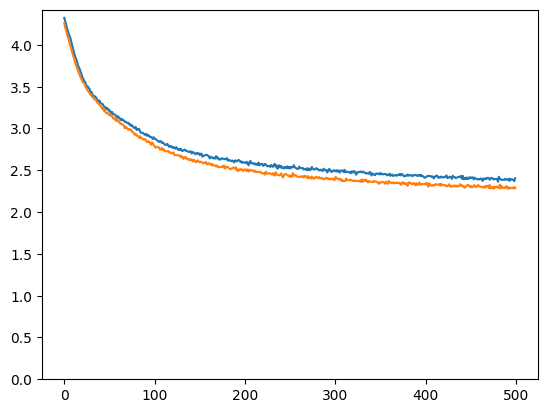

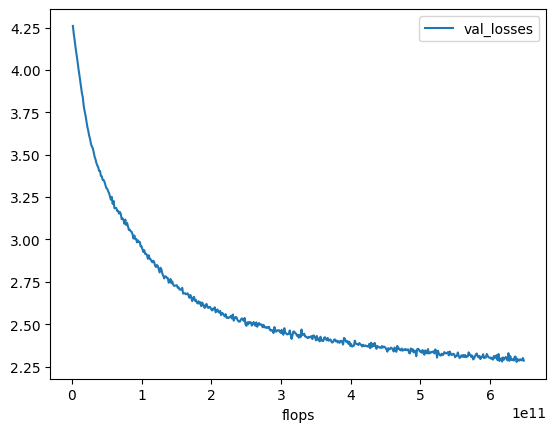

In [81]:
import pandas as pd

df = pd.DataFrame(metrics_basic_Shakespeare)
df['train_losses'].plot(ylim = 0)
df['val_losses'].plot(ylim=0)
df.plot(x = 'flops', y='val_losses')

## Big Model

In [24]:
class BigModel(torch.nn.Module):
    def __init__(self, big=False):
        super(BigModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, new_emb_size if big else emb_size)
        self.pe = PositionalEncoding(d_model= new_emb_size if big else emb_size)
        self.block1 = Block(big=big)
        self.block2 = Block(big=big)
        self.block3 = Block(big=big)
        self.block4 = Block(big=big)
        self.block5 = Block(big=big)
        self.block6 = Block(big=big)
        self.block7 = Block(big=big)
        self.block8 = Block(big=big)
        self.f_lin = torch.nn.Linear(new_emb_size if big else emb_size, vocab_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        r = self.f_lin(self.drop(m))
        return r

## Fused transformer Architecture

In [25]:
k_params = torch.empty((0,emb_size*emb_size)).to(device)
q_params = torch.empty((0,emb_size*emb_size)).to(device)
v_params = torch.empty((0,emb_size*emb_size)).to(device)
lin_params = torch.empty((0, 2*emb_size*emb_size)).to(device)
ffn_w_params = torch.empty((0, emb_size*emb_size)).to(device)
ffn_b_params = torch.empty((0, emb_size)).to(device)
l_norm_w_params = torch.empty((0, emb_size)).to(device)
l_norm_b_params = torch.empty((0, emb_size)).to(device)
for i in model.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)


In [26]:
class FusedEmbedding(torch.nn.Module):
    def __init__(self, emb_params, static=True, width=False, width_static=True):
        super(FusedEmbedding, self).__init__()
        self.static = static
        self.width_static = width_static
        self.width=width
        if static:
            if width:
                if width_static:
                    self.emb_params = torch.cat((emb_params, emb_params)).view(vocab_size, -1)
                else:
                    self.emb_params = emb_params.view(vocab_size, -1)
                    self.width_w = torch.nn.Linear(emb_size, new_emb_size, bias=False)
            else:
                self.emb_params = emb_params.view(vocab_size, -1)
        else:
            self.width = width
            self.emb_params = emb_params
    def forward(self, inp):
        emb = self.emb_params
        if self.static:
            if self.width:
                if self.width_static:
                    return torch.nn.functional.embedding(inp, emb)
                return torch.nn.functional.embedding(inp, self.width_w(emb))
        emb = emb.view(vocab_size, -1)
        return torch.nn.functional.embedding(inp, emb)

In [27]:
class FusedLin(torch.nn.Module):
    def __init__(self, num_layers, in_dim, out_dim, small_params_w, small_params_b = None, static = False, width_static=True, width=False, old_in_dim = emb_size, old_out_dim = emb_size):
        super( FusedLin, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.static = static
        self.width = width
        self.old_in_dim = old_in_dim
        self.old_out_dim = old_out_dim
        self.width_static = width_static
        self.final = True if out_dim == vocab_size else False
        if not self.final and static:
            if width:
                if width_static:
                    self.register_buffer('small_params_w', torch.kron(torch.eye(int(out_dim/old_out_dim), int(in_dim/old_in_dim)).to(device), small_params_w).view(out_dim, in_dim))
                    if small_params_b is not None:
                        if old_out_dim == out_dim:
                            self.register_buffer('small_params_b', small_params_b)
                        else:
                            self.register_buffer('small_params_b', torch.cat((small_params_b, small_params_b)))
                    else:
                        self.small_params_b = None
                else:
                    self.register_buffer('small_params_w', small_params_w)
                    self.width_wa = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width else None
                    self.width_wb = torch.nn.Linear(old_in_dim, in_dim, bias=False) if width else None
                    if small_params_b is not None:
                        self.register_buffer('small_params_b', small_params_b)
                    else:
                        self.small_params_b = None
                    self.width_b = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width and small_params_b is not None else None
            else:
                self.register_buffer('small_params_w', small_params_w.view(out_dim, in_dim))
                if small_params_b is not None:
                    self.register_buffer('small_params_b', small_params_b)
                else:
                    self.small_params_b = None
        else:
            self.width_wa = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width and not self.final else None
            self.width_wb = torch.nn.Linear(old_in_dim, in_dim, bias=False) if width else None
            self.width_b = torch.nn.Linear(old_out_dim, out_dim, bias=False) if width and small_params_b is not None and not self.final else None
            if not self.final:
                self.lin_w = torch.nn.Parameter(torch.rand(num_layers))
                if small_params_b is not None:
                    self.lin_b = torch.nn.Parameter(torch.rand(num_layers))
            self.register_buffer('small_params_w', small_params_w)
            if small_params_b is not None:
                self.register_buffer('small_params_b', small_params_b)
            else:
                self.small_params_b = None
    def forward(self, inp):
        if self.static and not self.final:
            weight=self.small_params_w
            bias=self.small_params_b
            if not self.width_static:
                weight = self.width_wb(weight.view(self.old_out_dim, self.old_in_dim))
                weight = self.width_wa(weight.T).T
                if bias is not None:
                    bias = self.width_b(bias)
            return torch.nn.functional.linear(inp, weight=weight, bias=bias)
        if self.final:
            weight = self.small_params_w
            bias = self.small_params_b
        else:
            weight = self.small_params_w.T @ self.lin_w
            bias = None
            if self.small_params_b is not None:
                bias = self.small_params_b.T@self.lin_b
        if self.width:
            if not self.final:
                weight = self.width_wb(weight.view(self.old_out_dim, self.old_in_dim))
                weight = self.width_wa(weight.T).T
            else:
                weight = self.width_wb(weight.view(self.old_out_dim, self.old_in_dim))
        if self.width_b is not None:
            bias = self.width_b(bias)
        weight = weight.view(self.out_dim, self.in_dim)
        return torch.nn.functional.linear(inp, weight, bias = bias)

In [28]:
class FusedNorm(torch.nn.Module):
    def __init__(self, num_layers, small_params_w, small_params_b, static=False, width_static = True, width=False):
        super(FusedNorm, self).__init__()
        self.static = static
        self.width = width
        self.width_static = width_static
        if not static:
            self.register_buffer('small_params_w', small_params_w)
            self.register_buffer('small_params_b', small_params_b)
            self.lin_w = torch.nn.Parameter(torch.randn(num_layers))
            self.lin_b = torch.nn.Parameter(torch.randn(num_layers))
            if width:
                self.width_w = torch.nn.Linear(emb_size, new_emb_size, bias=False)
                self.width_b = torch.nn.Linear(emb_size, new_emb_size, bias=False)
        else:
            if width:
                if width_static:
                    self.register_buffer('small_params_w', torch.cat((small_params_w, small_params_w)))
                    self.register_buffer('small_params_b', torch.cat((small_params_b, small_params_b)))
                else:
                    self.register_buffer('small_params_w', small_params_w)
                    self.register_buffer('small_params_b', small_params_b)
                    self.width_w = torch.nn.Linear(emb_size, new_emb_size, bias=False)
                    self.width_b = torch.nn.Linear(emb_size, new_emb_size, bias=False)
            else:
                self.register_buffer('small_params_w', small_params_w)
                self.register_buffer('small_params_b', small_params_b)
    def forward(self, inp):
        if self.static:
            weight = self.small_params_w
            bias = self.small_params_b
            e_s = emb_size if not self.width else new_emb_size
            if not self.width_static:
                weight = self.width_w(weight)
                bias = self.width_b(bias)
            return torch.nn.functional.layer_norm(inp, tuple([e_s]), weight=weight, bias=bias)
        weight = self.small_params_w.T @ self.lin_w
        bias = self.small_params_b.T @ self.lin_b
        if self.width:
            weight = self.width_w(weight)
            bias = self.width_b(bias)
        e_s = emb_size if not self.width else new_emb_size
        return torch.nn.functional.layer_norm(inp, tuple([e_s]), weight=weight, bias=bias)


In [29]:
class FusedAttentionHead(torch.nn.Module):
    def __init__(self, static=False, layerNum=None, width=False, width_static = True):
        super( FusedAttentionHead, self).__init__()
        self.static = static
        self.width_static = width_static
        if not static:
            self.k = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, k_params, width=width, width_static=width_static)
            self.q = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, q_params, width=width, width_static=width_static)
            self.v = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, v_params, width=width, width_static=width_static)
        else:
            self.k = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, k_params[layerNum], static=True, width=width, width_static=width_static)
            self.q = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, q_params[layerNum], static=True, width=width, width_static=width_static)
            self.v = FusedLin(num_small_layers*multi_heads, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, v_params[layerNum], static=True, width=width, width_static=width_static)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
    def forward(self, e):
        keys = self.k(e)
        queries = self.q(e)
        values = self.v(e)
        ret = keys @ queries.transpose(1, 2)*(1.0/math.sqrt(keys.size(-1)))
        ret = torch.masked_fill(ret, self.tril==0, -torch.inf)
        ret = torch.softmax(ret, 2)
        ret = ret @ values
        return ret

In [30]:
class FusedMultiHead(torch.nn.Module):
    def __init__(self, static=False, layerNum=None, width=False, width_static = True):
        super( FusedMultiHead, self).__init__()
        self.drop = torch.nn.Dropout(0.1)
        self.width_static = width_static
        if not static:
            self.head1 = FusedAttentionHead(width=width, width_static=width_static)
            self.head2 = FusedAttentionHead(width=width, width_static=width_static)
            self.mh_lin = FusedLin(num_small_layers, multi_heads*(emb_size if not width else new_emb_size), emb_size if not width else new_emb_size, lin_params, width=width, old_in_dim=multi_heads*emb_size , old_out_dim=emb_size, width_static=width_static)
        else:
            self.head1 = FusedAttentionHead(static=True, layerNum=2*layerNum, width=width, width_static=width_static)
            self.head2 = FusedAttentionHead(static=True, layerNum=2*layerNum+1, width=width, width_static=width_static)
            self.mh_lin = FusedLin(num_small_layers, multi_heads*(emb_size if not width else new_emb_size), emb_size if not width else new_emb_size, lin_params[layerNum], static=True, width=width, width_static=width_static, old_in_dim=multi_heads*emb_size, old_out_dim=emb_size)
    def forward(self, inp):
        x1 = self.head1(inp)
        x2 = self.head2(inp)
        return self.mh_lin(self.drop(torch.cat([x1,x2], dim=2))).relu()

In [31]:
class FusedBlock(torch.nn.Module):
    def __init__(self, static=False, layerNum=None, width=False, width_static = True):
        super(FusedBlock, self).__init__()
        self.static = static
        self.width_static = width_static
        self.drop = torch.nn.Dropout(0.1)
        if not static:
            self.multiHead = FusedMultiHead(width=width, width_static=width_static)
            self.norm_1 = FusedNorm(num_small_layers*2, l_norm_w_params, l_norm_b_params, width=width, width_static=width_static)
            self.norm_2 = FusedNorm(num_small_layers*2, l_norm_w_params, l_norm_b_params, width=width, width_static=width_static)
            self.ffn = FusedLin(num_small_layers, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, ffn_w_params, ffn_b_params, width=width, width_static=width_static)
        else:
            self.multiHead = FusedMultiHead(static=True, layerNum=layerNum, width=width, width_static=width_static)
            self.norm_1 = FusedNorm(num_small_layers*2, l_norm_w_params[layerNum*2], l_norm_b_params[layerNum*2], static=True, width=width, width_static=width_static)
            self.norm_2 = FusedNorm(num_small_layers*2, l_norm_w_params[layerNum*2+1], l_norm_b_params[layerNum*2+1], static=True, width=width, width_static=width_static)
            self.ffn = FusedLin(num_small_layers, emb_size if not width else new_emb_size, emb_size if not width else new_emb_size, ffn_w_params[layerNum], ffn_b_params[layerNum], static=True, width=width, width_static=width_static)
    def forward(self, inp):
        m = self.norm_1(inp + self.multiHead(inp))
        m = self.norm_2(m + self.ffn(self.drop(m)).relu())
        return m


## LiGO & CrossLiGO

In [32]:
class StackLiGO(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(StackLiGO, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten().clone(), width=width, static=True)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(static=True, layerNum=0, width=width)
        self.block2 = FusedBlock(static=True, layerNum=1, width=width)
        self.block3 = FusedBlock(static=True, layerNum=2, width=width)
        self.block4 = FusedBlock(static=True, layerNum=3, width=width)
        self.block5 = FusedBlock(width=width)
        self.block6 = FusedBlock(width=width)
        self.block7 = FusedBlock(width=width)
        self.block8 = FusedBlock(width=width)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten().clone(), small_params_b=model.f_lin.bias.clone(), width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [33]:
class StackLiGOv2(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(StackLiGOv2, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten().clone(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(static=True, layerNum=0, width=width, width_static=False)
        self.block2 = FusedBlock(static=True, layerNum=1, width=width, width_static=False)
        self.block3 = FusedBlock(static=True, layerNum=2, width=width, width_static=False)
        self.block4 = FusedBlock(static=True, layerNum=3, width=width, width_static=False)
        self.block5 = FusedBlock(width=width)
        self.block6 = FusedBlock(width=width)
        self.block7 = FusedBlock(width=width)
        self.block8 = FusedBlock(width=width)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten().clone(), small_params_b=model.f_lin.bias.clone(), width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [34]:
class LiGO(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(LiGO, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten().clone(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(width=width, width_static=False)
        self.block2 = FusedBlock(width=width, width_static=False)
        self.block3 = FusedBlock(width=width, width_static=False)
        self.block4 = FusedBlock(width=width, width_static=False)
        self.block5 = FusedBlock(width=width, width_static=False)
        self.block6 = FusedBlock(width=width, width_static=False)
        self.block7 = FusedBlock(width=width, width_static=False)
        self.block8 = FusedBlock(width=width, width_static=False)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten().clone(), small_params_b=model.f_lin.bias.clone(), width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))

In [35]:
class CrossLiGO(torch.nn.Module):
    def __init__(self, width=False) -> None:
        super(CrossLiGO, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten().detach().clone(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(static=True, layerNum=0, width=width)
        self.block3 = FusedBlock(static=True, layerNum=1, width=width)
        self.block5 = FusedBlock(static=True, layerNum=2, width=width)
        self.block7 = FusedBlock(static=True, layerNum=3, width=width)
        self.block2 = FusedBlock(width=width, width_static=False)
        self.block4 = FusedBlock(width=width, width_static=False)
        self.block6 = FusedBlock(width=width, width_static=False)
        self.block8 = FusedBlock(width=width, width_static=False)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten().clone().to(device), small_params_b=model.f_lin.bias.detach().clone().to(device), width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        return self.f_lin(self.drop(m))


In [36]:
class LiGO_W(torch.nn.Module):
    def __init__(self, width=True) -> None:
        super(LiGO_W, self).__init__()
        self.emb = FusedEmbedding(emb_params=model.embedding.weight.flatten(), width=width, static=True, width_static=False)
        self.pe = PositionalEncoding(d_model=new_emb_size if width else emb_size)
        self.block1 = FusedBlock(width=width, static=True, layerNum=0, width_static=False)
        self.block2 = FusedBlock(width=width, static=True, layerNum=1, width_static=False)
        self.block3 = FusedBlock(width=width, static=True, layerNum=2, width_static=False)
        self.block4 = FusedBlock(width=width, static=True, layerNum=3, width_static=False)
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(1, in_dim=emb_size if not width else new_emb_size, out_dim=vocab_size, static=True, small_params_w= model.f_lin.weight.flatten(), small_params_b=model.f_lin.bias, width=width, old_in_dim=emb_size, old_out_dim=vocab_size)
    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        return self.f_lin(self.drop(m))
     

In [37]:
@torch.no_grad()
def initLiGO(stackLiGO, bigModel):
    # Embedding layer
    emb = stackLiGO.emb.emb_params
    if stackLiGO.emb.width and not stackLiGO.emb.width_static:
        emb = stackLiGO.emb.width_w(emb)
    setattr(bigModel.embedding, 'weight', torch.nn.Parameter(emb, requires_grad=True).to(device))
    # Final Linear layer
    f_lin_w = stackLiGO.f_lin.small_params_w.view(vocab_size, -1)
    f_lin_b = stackLiGO.f_lin.small_params_b
    if stackLiGO.f_lin.width:
        f_lin_w = (stackLiGO.f_lin.width_wb(f_lin_w))
        # f_lin_w = (stackLiGO.f_lin.width_wa(f_lin_w.T)).T     Issues with big vocab size
        # f_lin_b = stackLiGO.f_lin.width_b.weight@f_lin_b
    setattr(bigModel.f_lin, 'weight', torch.nn.Parameter(f_lin_w.view(vocab_size, -1), requires_grad=True).to(device))
    setattr(bigModel.f_lin, 'bias', torch.nn.Parameter(f_lin_b, requires_grad=True).to(device))
    num_layers = num_large_layers if type(stackLiGO) is not LiGO_W else num_small_layers
    for i in range(1, num_layers+1):
        fused_block = getattr(stackLiGO, f'block{i}')
        big_block = getattr(bigModel, f'block{i}')
        # Setting FFN Weights
        if fused_block.ffn.static:
            if fused_block.ffn.width:
                if fused_block.ffn.width_static:
                    fb_w = fused_block.ffn.small_params_w.view(new_emb_size, new_emb_size)
                    fb_b = fused_block.ffn.small_params_b
                else:
                    fb_w = fused_block.ffn.small_params_w.view(emb_size, emb_size)
                    fb_b = fused_block.ffn.small_params_b
                    fb_w = fused_block.ffn.width_wb(fb_w)
                    fb_w = fused_block.ffn.width_wa(fb_w.T).T
                    fb_b = fused_block.ffn.width_b.weight@fb_b
            else:
                fb_w = fused_block.ffn.small_params_w.view(emb_size, emb_size)
                fb_b = fused_block.ffn.small_params_b
        else:
            fb_w = (ffn_w_params.T@fused_block.ffn.lin_w).view(emb_size, emb_size)
            fb_b = (ffn_b_params.T@fused_block.ffn.lin_b)
            if fused_block.ffn.width:
                fb_w = fused_block.ffn.width_wb(fb_w)
                fb_w = fused_block.ffn.width_wa(fb_w.T).T
                fb_b = fused_block.ffn.width_b.weight@fb_b
        setattr(big_block.ffn, 'weight', torch.nn.Parameter(fb_w, requires_grad=True).to(device))
        setattr(big_block.ffn, 'bias', torch.nn.Parameter(fb_b, requires_grad=True).to(device))
        # Setting Norm Layers
        if fused_block.static:
            n_w_1 = fused_block.norm_1.small_params_w
            n_b_1 = fused_block.norm_1.small_params_b
            n_w_2 = fused_block.norm_2.small_params_w
            n_b_2 = fused_block.norm_2.small_params_b
            if not fused_block.width_static:
                n_w_1 = fused_block.norm_1.width_w.weight@n_w_1
                n_b_1 = fused_block.norm_1.width_b.weight@n_b_1
                n_w_2 = fused_block.norm_2.width_w.weight@n_w_2
                n_b_2 = fused_block.norm_2.width_b.weight@n_b_2
        else:
            n_w_1 = (l_norm_w_params.T@fused_block.norm_1.lin_w)
            n_b_1 = (l_norm_b_params.T@fused_block.norm_1.lin_b)
            n_w_2 = (l_norm_w_params.T@fused_block.norm_2.lin_w)
            n_b_2 = (l_norm_b_params.T@fused_block.norm_2.lin_b)
            if fused_block.norm_1.width:
                n_w_1 = fused_block.norm_1.width_w.weight@n_w_1
                n_b_1 = fused_block.norm_1.width_b.weight@n_b_1
                n_w_2 = fused_block.norm_2.width_w.weight@n_w_2
                n_b_2 = fused_block.norm_2.width_b.weight@n_b_2
        setattr(big_block.l_norm_1, 'weight', torch.nn.Parameter(n_w_1, requires_grad=True).to(device))
        setattr(big_block.l_norm_1, 'bias', torch.nn.Parameter(n_b_1, requires_grad=True).to(device))
        setattr(big_block.l_norm_2, 'weight', torch.nn.Parameter(n_w_2, requires_grad=True).to(device))
        setattr(big_block.l_norm_2, 'bias', torch.nn.Parameter(n_b_2, requires_grad=True).to(device))
        # Setting Multi-Head Attention
        if fused_block.static:
            mh = fused_block.multiHead.mh_lin.small_params_w
            if not fused_block.width_static:
                mh = fused_block.multiHead.mh_lin.width_wb(mh.view(emb_size, multi_heads*emb_size))
                mh = fused_block.multiHead.mh_lin.width_wa(mh.T).T
        else:
            mh = (lin_params.T@fused_block.multiHead.mh_lin.lin_w).view(emb_size, emb_size*multi_heads)
            if fused_block.multiHead.mh_lin.width:
                mh = fused_block.multiHead.mh_lin.width_wb(mh)
                mh = fused_block.multiHead.mh_lin.width_wa(mh.T).T
        setattr(big_block.multihead.mh_lin, 'weight', torch.nn.Parameter(mh, requires_grad=True))
        for h in range(1, multi_heads+1):
            head = getattr(big_block.multihead, f'head{h}')
            fused_head = getattr(fused_block.multiHead, f'head{h}')
            if fused_head.static:
                k = fused_head.k.small_params_w
                q = fused_head.q.small_params_w
                v = fused_head.v.small_params_w
                if not fused_block.width_static:
                    k = fused_head.k.width_wb(k.view(emb_size, emb_size))
                    k = fused_head.k.width_wa(k.T).T
                    q = fused_head.q.width_wb(q.view(emb_size, emb_size))
                    q = fused_head.q.width_wa(q.T).T
                    v = fused_head.v.width_wb(v.view(emb_size, emb_size))
                    v = fused_head.v.width_wa(v.T).T
            else:
                k = (k_params.T@fused_head.k.lin_w).view(emb_size, emb_size)
                q = (q_params.T@fused_head.q.lin_w).view(emb_size, emb_size)
                v = (v_params.T@fused_head.v.lin_w).view(emb_size, emb_size)
                if fused_head.k.width:
                    k = fused_head.k.width_wb(k)
                    k = fused_head.k.width_wa(k.T).T
                    q = fused_head.q.width_wb(q)
                    q = fused_head.q.width_wa(q.T).T
                    v = fused_head.v.width_wb(v)
                    v = fused_head.v.width_wa(v.T).T
            setattr(head.k, 'weight', torch.nn.Parameter(k, requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter(q, requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter(v, requires_grad=True).to(device))

## Comparative study models

### Scratch

In [38]:
bigModel_scratch = BigModel(big=True).to(device)
optim_sb = torch.optim.Adam(params=bigModel_scratch.parameters(), lr=1e-3)
scratch_depth_width = train(bigModel_scratch, optim_sb, 500)

<Axes: >

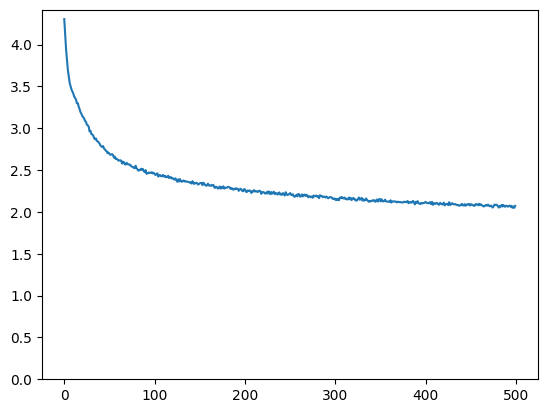

In [39]:
big_model_metrics = pd.DataFrame(scratch_depth_width)
big_model_metrics['train_losses'].plot(ylim = 0)

## Stacking

In [40]:
import torch.nn as nn

class StackedModel(nn.Module):
    def __init__(self, pretrained_model):
        super(StackedModel, self).__init__()

        # Use pretrained model's components
        self.embedding = pretrained_model.embedding
        self.pe = pretrained_model.pe
        self.f_lin = pretrained_model.f_lin
        self.drop = pretrained_model.drop

        # Add pretrained blocks (1-4)
        self.blocks = nn.ModuleList(pretrained_model.blocks)
        
        # Add additional blocks according to the pattern: 5-1, 6-2, 7-3, 8-4
        # Block 5 -> Block 1, Block 6 -> Block 2, Block 7 -> Block 3, Block 8 -> Block 4
        self.blocks.append(pretrained_model.blocks[0])  # Block 5
        self.blocks.append(pretrained_model.blocks[1])  # Block 6
        self.blocks.append(pretrained_model.blocks[2])  # Block 7
        self.blocks.append(pretrained_model.blocks[3])  # Block 8

    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)

        # Pass input through all blocks sequentially
        for block in self.blocks:
            e = block(e)

        r = self.f_lin(self.drop(e))
        return r

In [41]:
stacked_model = StackedModel(model)
optim_stacked = torch.optim.Adam(params=stacked_model.parameters(), lr=1e-2)
stacked_metrics = train(stacked_model, optim_stacked, 500)

### LiGO Depth only

In [42]:
LiGO_bool = True
block_size = 8
batch_size = 2048
val_batch_size = 2048
vocab_size = len(chars)
emb_size = 32
new_emb_size = 64
num_small_layers = 4
multi_heads = 2
num_large_layers = 8

In [43]:
LiGO_d = LiGO(width=False).to(device)
optim_ld = torch.optim.Adam(params=LiGO_d.parameters(), lr=1e-2)
_=train(LiGO_d, optim_ld, 200)

In [44]:
bigModel = BigModel(big=False).to(device)
initLiGO(LiGO_d, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
ligo_depth_metrics = train(bigModel, optim_b, 500)

### CrossLiGO depth only

In [45]:
cl_d = CrossLiGO(width=False).to(device)
optim_ldw = torch.optim.Adam(cl_d.parameters(), lr=1e-2)
_=train(cl_d, optim_ldw, 200)

In [46]:
bigModel = BigModel(big=False).to(device)
initLiGO(cl_d, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
cl_depth_metrics = train(bigModel, optim_b, 500)

### StackLiGO depth only

In [47]:
stackLiGOd = StackLiGO(width=False).to(device)
optim_sld = torch.optim.Adam(params=stackLiGOd.parameters(), lr=1e-2)
_=train(stackLiGOd, optim_sld, 200)

In [48]:
bigModel = BigModel(big=False).to(device)
initLiGO(stackLiGOd, bigModel)
optim_b = torch.optim.Adam(params=bigModel.parameters(), lr=1e-3)
sl_depth_metrics = train(bigModel, optim_b, 500)

# When to grow

## Periodic

0 -> 8

pretrained(4) -> 8

In [82]:
base_model = model.to(device)
periodic_optimizer = torch.optim.Adam(base_model.parameters(), lr = 1e-3)
metrics_pretrained_periodic = periodic_train(base_model, periodic_optimizer, 500, 4)

Adding new block at epoch 100
added successfully
Adding new block at epoch 200
added successfully
Adding new block at epoch 300
added successfully
Adding new block at epoch 400
added successfully


<Axes: >

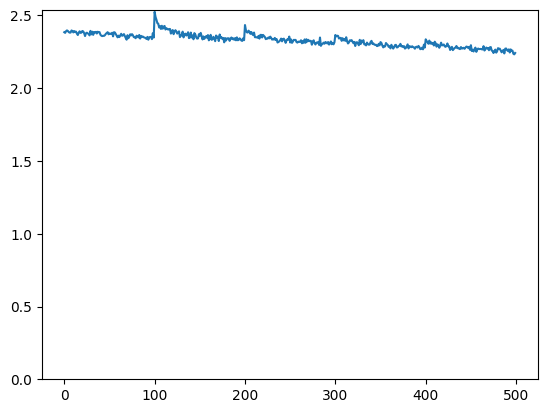

In [83]:
import pandas as pd

df = pd.DataFrame(metrics_pretrained_periodic)
df['train_losses'].plot(ylim = 0)

In [52]:
base_model = Model(1)
periodic_optimizer = torch.optim.Adam(base_model.parameters(), lr = 1e-3)
metrics_basic_periodic = periodic_train(base_model, periodic_optimizer, 500, 8)

Adding new block at epoch 55
added successfully
Adding new block at epoch 110
added successfully
Adding new block at epoch 165
added successfully
Adding new block at epoch 220
added successfully
Adding new block at epoch 275
added successfully
Adding new block at epoch 330
added successfully
Adding new block at epoch 385
added successfully
Adding new block at epoch 440
added successfully
Adding new block at epoch 495
added successfully


<Axes: >

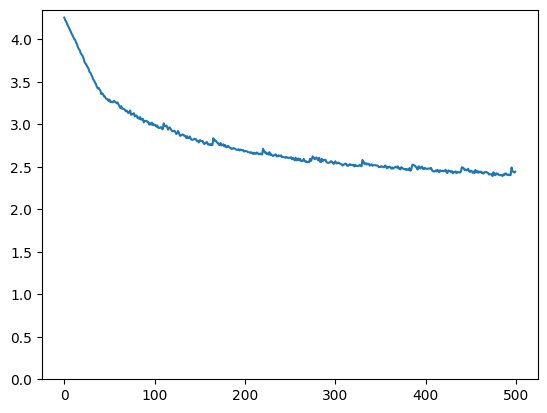

In [53]:
import pandas as pd

df = pd.DataFrame(metrics_basic_periodic)
df['train_losses'].plot(ylim = 0)

## Convergence Growth

In [54]:
base_model = Model(1).to(device)
convergence_optimizer = torch.optim.Adam(base_model.parameters(), lr = 1e-3)
metrics_basic_convergence = convergence_train(base_model, convergence_optimizer, 500, 8, patience=5, threshold=1e-3, moving_avg_window=5, stability_threshold=0.002)

Forcing block addition at epoch 55 due to period interval.
Added successfully
Stable loss detected at epoch 57, adding block.
Added successfully
Stable loss detected at epoch 114, adding block.
Added successfully
Stable loss detected at epoch 168, adding block.
Added successfully
Stable loss detected at epoch 222, adding block.
Added successfully
Stable loss detected at epoch 278, adding block.
Added successfully
Stable loss detected at epoch 331, adding block.
Added successfully
Stable loss detected at epoch 386, adding block.
Added successfully


<Axes: >

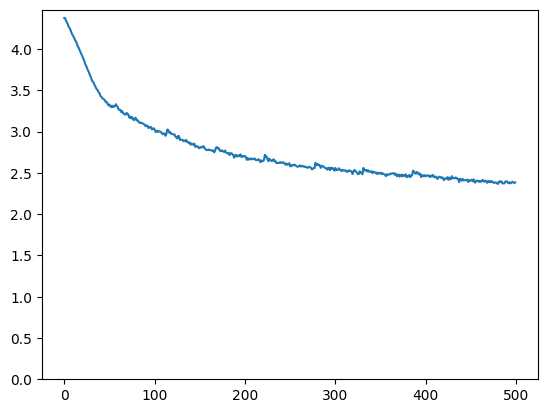

In [55]:
import pandas as pd

df = pd.DataFrame(metrics_basic_convergence)
df['train_losses'].plot(ylim = 0)

In [56]:
base_model = model.to(device)
convergence_optimizer = torch.optim.Adam(base_model.parameters(), lr = 1e-3)
metrics_pretrained_convergence = convergence_train(base_model, convergence_optimizer, 500, 4, patience=5, threshold=1e-3, moving_avg_window=5, stability_threshold=0.002)

Stable loss detected at epoch 9, adding block.
Added successfully
Stable loss detected at epoch 101, adding block.
Added successfully
Stable loss detected at epoch 201, adding block.
Added successfully
Stable loss detected at epoch 306, adding block.
Added successfully


<Axes: >

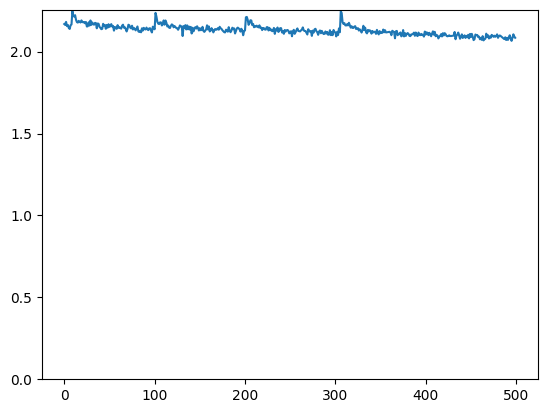

In [57]:
import pandas as pd

df = pd.DataFrame(metrics_pretrained_convergence)
df['train_losses'].plot(ylim = 0)

## FRAWGrow

In [58]:
# 0 -> 8
base_model = Model(1).to(device)
fragrow_optimizer = torch.optim.Adam(base_model.parameters(), lr = 1e-3)
metrics_basic_frawgrow = FRAWGrow_train(base_model, fragrow_optimizer, epochs=500, num_blocks=4, alpha=4.0, min_fine_tuning_epochs=100)

Growth condition met at epoch 100, adding block.
Added successfully
Growth condition met at epoch 101, adding block.
Added successfully
Growth condition met at epoch 201, adding block.
Added successfully
Growth condition met at epoch 301, adding block.
Added successfully


<Axes: >

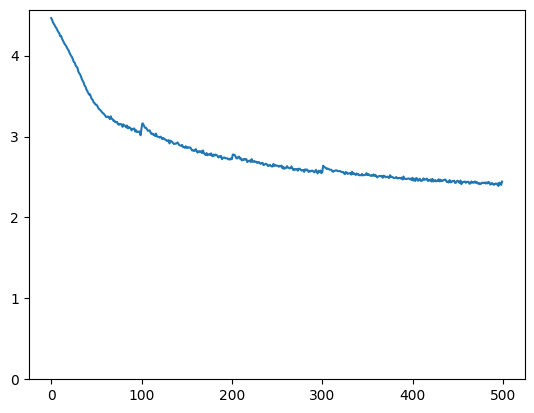

In [59]:
import pandas as pd

df = pd.DataFrame(metrics_basic_frawgrow)
df['train_losses'].plot(ylim = 0)

In [60]:
# 4 -> 8
base_model = model.to(device)
fragrow_optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
metrics_pretrained_frawgrow = FRAWGrow_train(base_model, fragrow_optimizer, epochs=500, num_blocks=4, alpha=4.0, min_fine_tuning_epochs=100)

Growth condition met at epoch 100, adding block.
Added successfully
Growth condition met at epoch 101, adding block.
Added successfully
Growth condition met at epoch 201, adding block.
Added successfully
Growth condition met at epoch 301, adding block.
Added successfully


<Axes: >

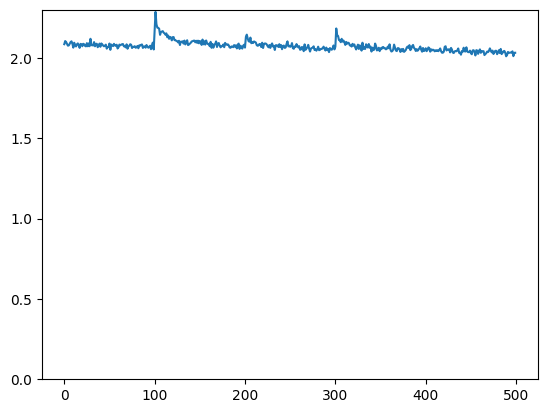

In [61]:
import pandas as pd

df = pd.DataFrame(metrics_pretrained_frawgrow)
df['train_losses'].plot(ylim = 0)

# Plots

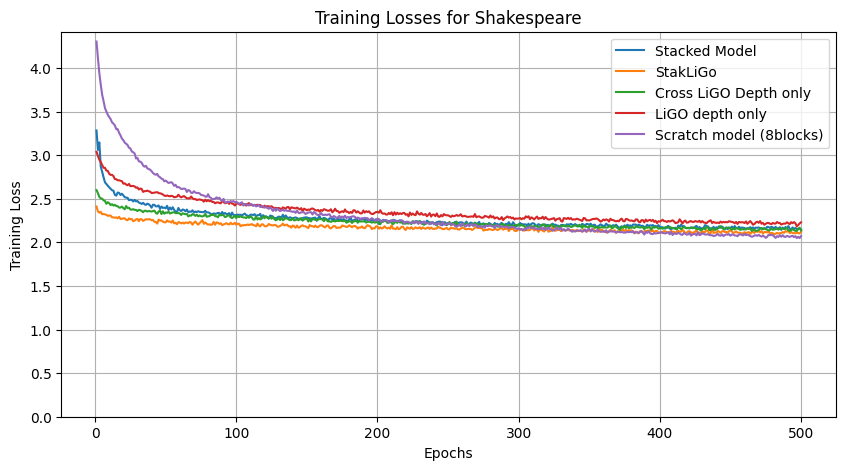

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Model names for reference
model_names = ["Stacked Model", "StakLiGo", "Cross LiGO Depth only", "LiGO depth only", "Scratch model (8blocks)"]
metrics_dfs = {
    "Stacked Model": pd.DataFrame(stacked_metrics),
    "StakLiGo": pd.DataFrame(sl_depth_metrics),
    "Cross LiGO Depth only": pd.DataFrame(cl_depth_metrics),
    "LiGO depth only": pd.DataFrame(ligo_depth_metrics),
    "Scratch model (8blocks)": pd.DataFrame(scratch_depth_width),
}

plt.figure(figsize=(10, 5))
for model1 in model_names:
    plt.plot(range(1, 501), metrics_dfs[model1]["train_losses"][:500], label=model1)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Losses for Shakespeare")
plt.legend()
plt.grid()
plt.ylim(bottom=0)  # Set Y-axis to start from 0
plt.show()


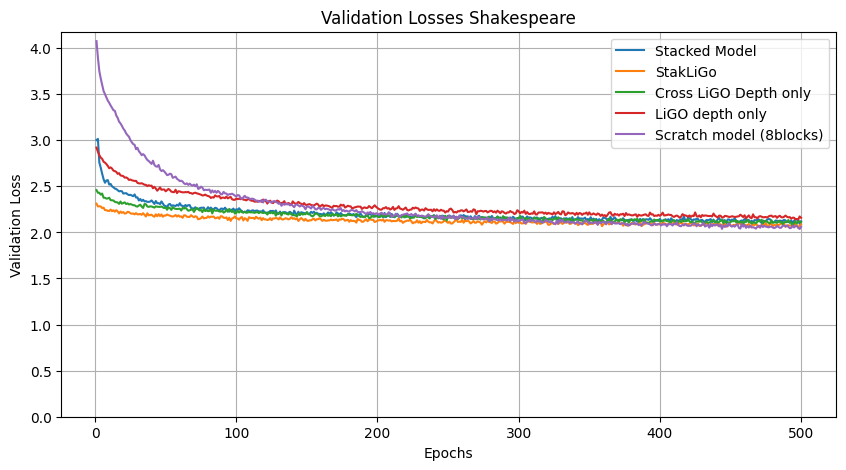

In [76]:
plt.figure(figsize=(10, 5))
for model1 in model_names:
    plt.plot(range(1, 501), metrics_dfs[model1]["val_losses"][:500], label=model1)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Losses Shakespeare")
plt.legend()
plt.grid()
plt.ylim(bottom=0)  # Set Y-axis to start from 0
plt.show()


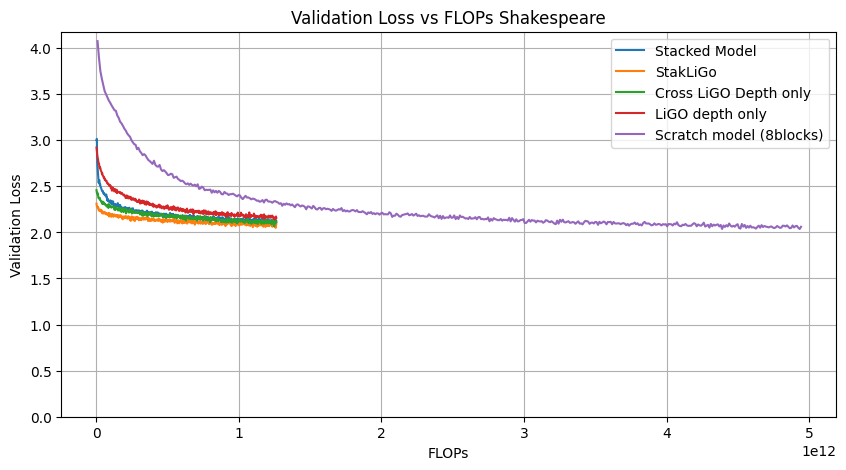

In [78]:
plt.figure(figsize=(10, 5))
for model1 in model_names:
    df = metrics_dfs[model1].sort_values(by="flops")  # Ensure FLOPs are sorted
    plt.plot(df["flops"], df["val_losses"], label=model1, linestyle='-')  # Line graph with markers
plt.xlabel("FLOPs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs FLOPs Shakespeare")
plt.legend()
plt.grid()
plt.ylim(bottom=0)  # Set Y-axis to start from 0
plt.show()


# All plots

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Model names for reference
model_names = [
    "Stacked Model", 
    "StakLiGo", 
    "Cross LiGO Depth only", 
    "LiGO depth only", 
    "Scratch model (8blocks)", 
    "Base model (4blocks)", 
    "Periodic pretrained 4 -> 8", 
    "Periodic 0 -> 8", 
    "Convergence pretrained 4 -> 8", 
    "Convergence 0 -> 8", 
    "FrawGrow pretrained 4 -> 8", 
    "FrawGrow 0 -> 8"
]

metrics_dfs = {
    "Stacked Model": pd.DataFrame(stacked_metrics),
    "StakLiGo": pd.DataFrame(sl_depth_metrics),
    "Cross LiGO Depth only": pd.DataFrame(cl_depth_metrics),
    "LiGO depth only": pd.DataFrame(ligo_depth_metrics),
    "Scratch model (8blocks)": pd.DataFrame(scratch_depth_width),
    "Base model (4blocks)": pd.DataFrame(metrics_basic_Shakespeare),
    "Periodic pretrained 4 -> 8": pd.DataFrame(metrics_pretrained_periodic),
    "Periodic 0 -> 8": pd.DataFrame(metrics_basic_periodic),
    "Convergence pretrained 4 -> 8": pd.DataFrame(metrics_pretrained_convergence),
    "Convergence 0 -> 8": pd.DataFrame(metrics_basic_convergence),
    "FrawGrow pretrained 4 -> 8": pd.DataFrame(metrics_pretrained_frawgrow),
    "FrawGrow 0 -> 8": pd.DataFrame(metrics_basic_frawgrow),
    
}

### Training Loss

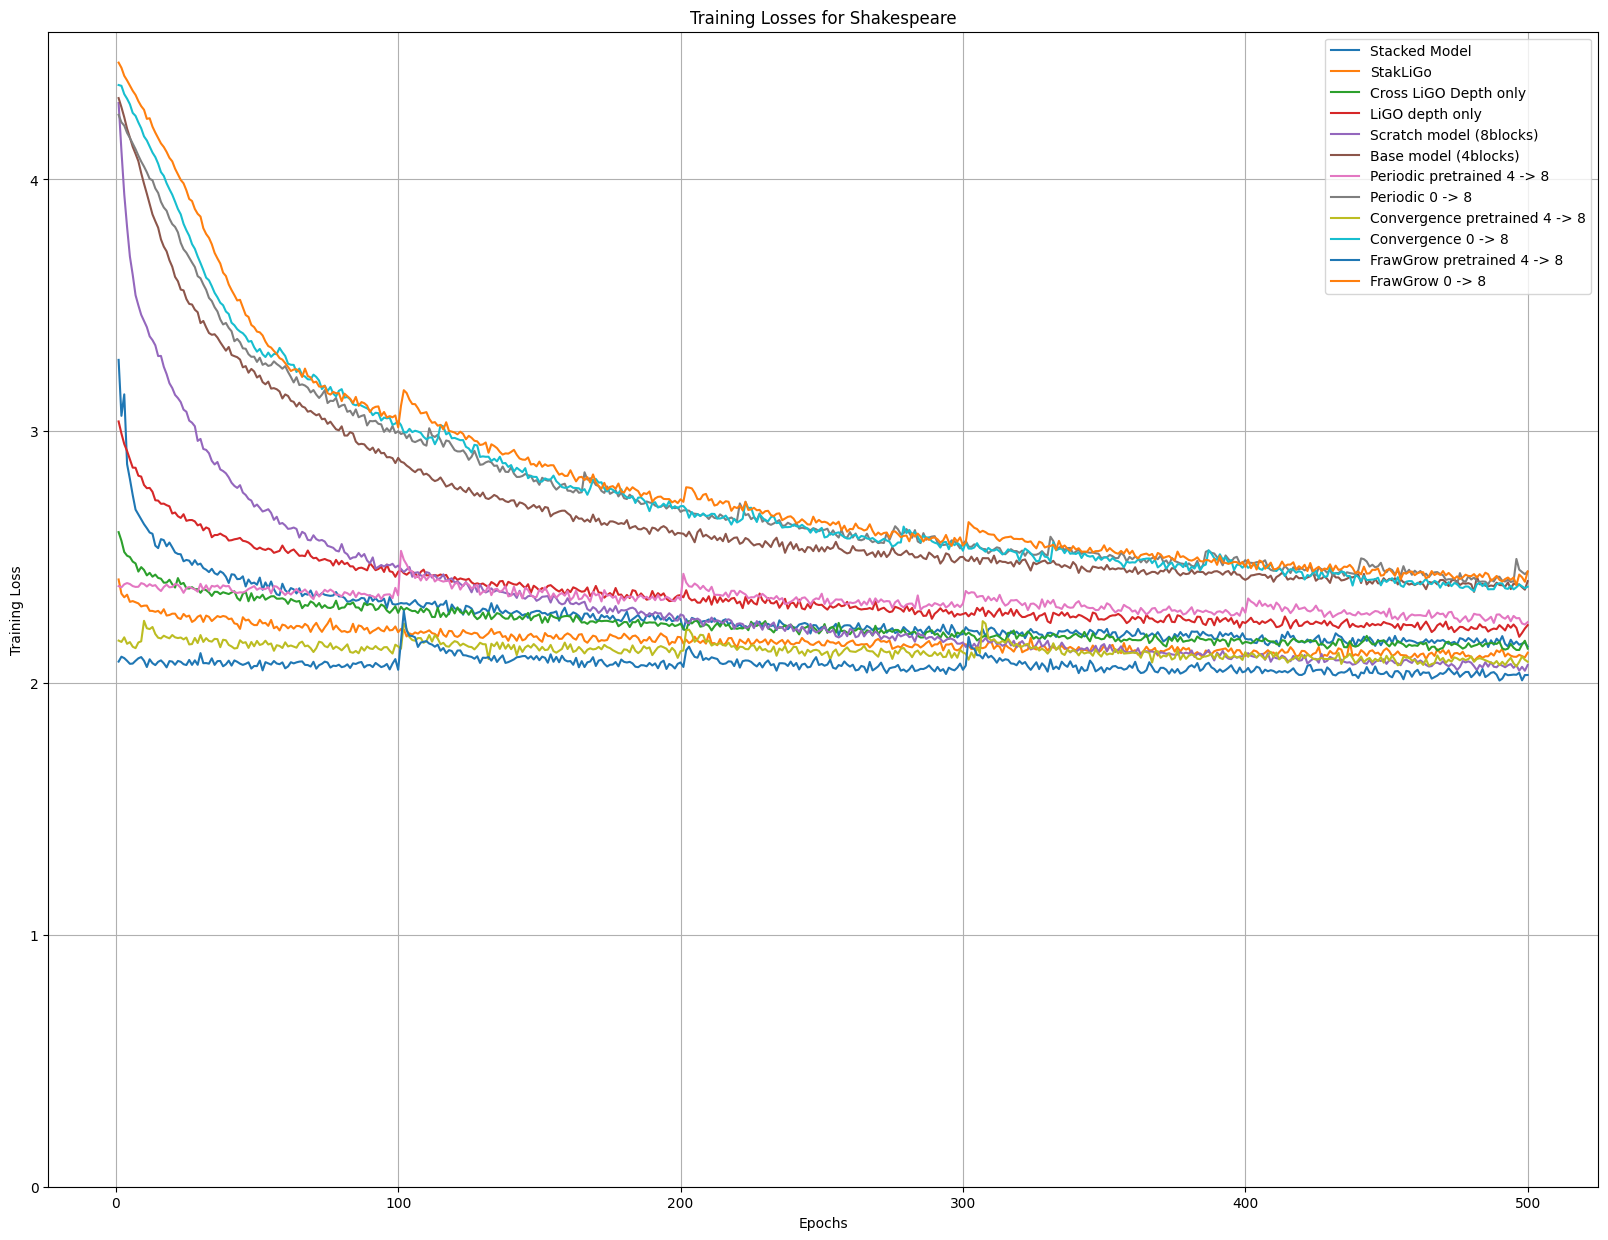

In [89]:
plt.figure(figsize=(20, 15))
for model1 in model_names:
    plt.plot(range(1, 501), metrics_dfs[model1]["train_losses"][:500], label=model1)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Losses for Shakespeare")
plt.legend()
plt.grid()
plt.ylim(bottom=0)  # Set Y-axis to start from 0
plt.show()


### Validation loss

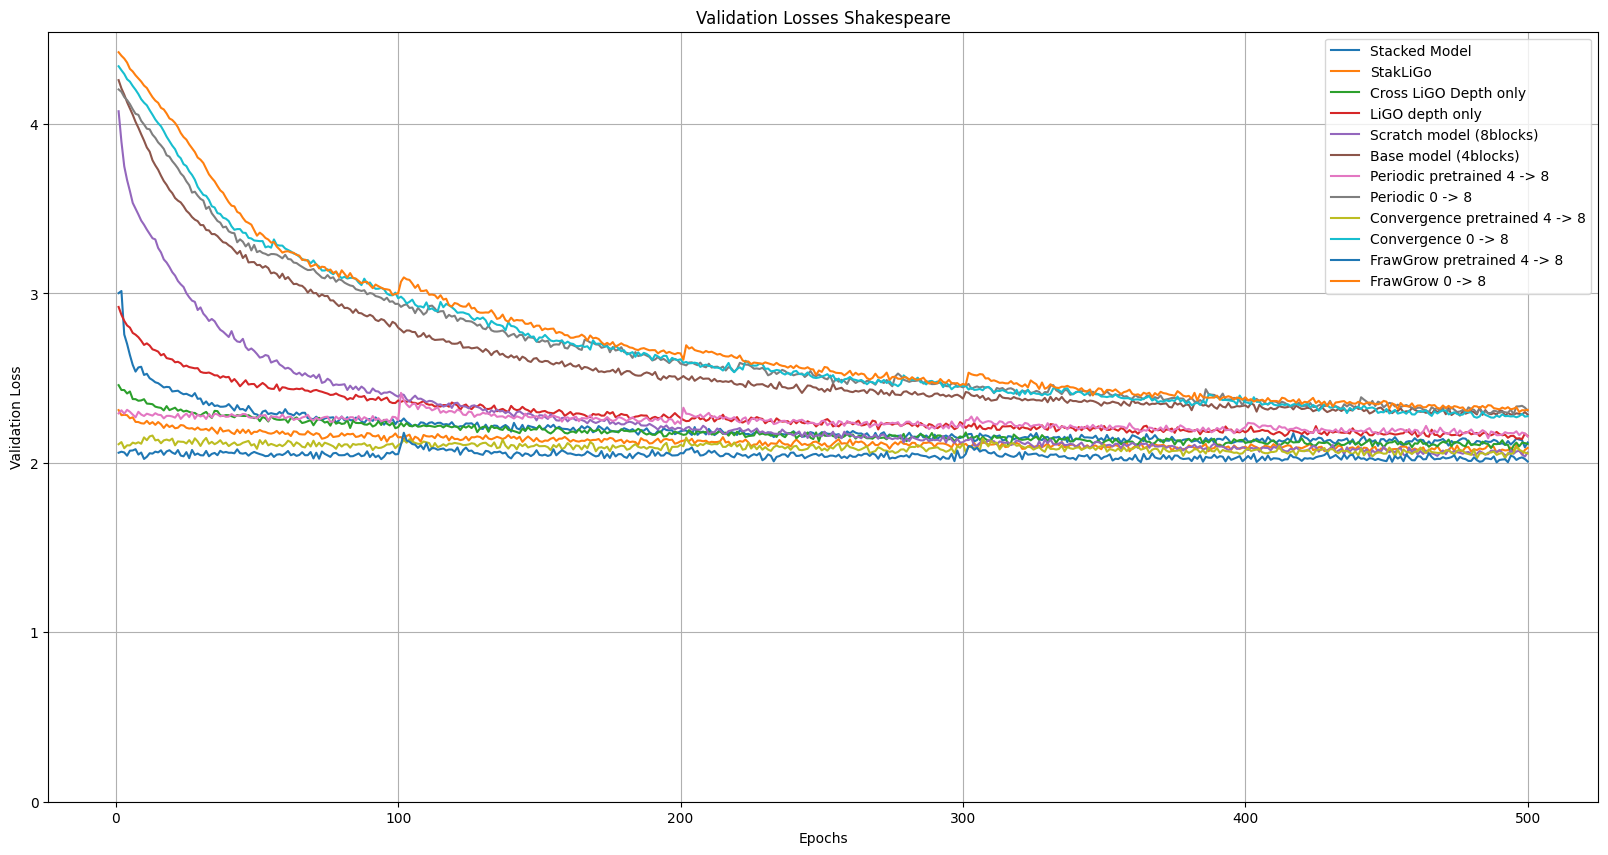

In [90]:
plt.figure(figsize=(20, 10))
for model1 in model_names:
    plt.plot(range(1, 501), metrics_dfs[model1]["val_losses"][:500], label=model1)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Losses Shakespeare")
plt.legend()
plt.grid()
plt.ylim(bottom=0)  # Set Y-axis to start from 0
plt.show()


### Validation Loss Vs. TFLOPs

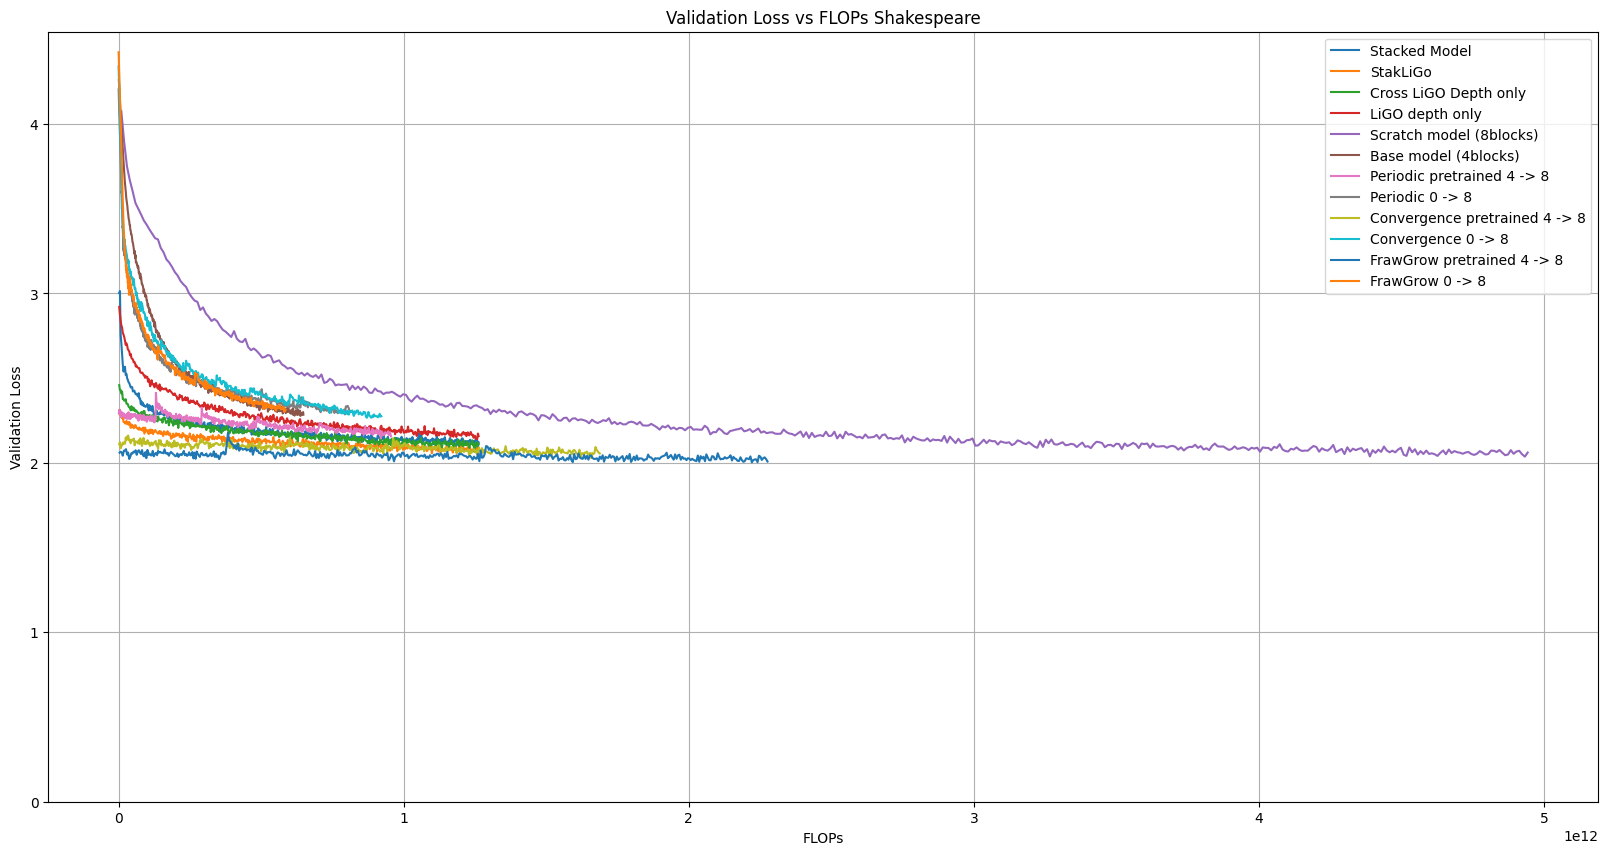

In [91]:
plt.figure(figsize=(20, 10))
for model1 in model_names:
    df = metrics_dfs[model1].sort_values(by="flops")  # Ensure FLOPs are sorted
    plt.plot(df["flops"], df["val_losses"], label=model1, linestyle='-')  # Line graph with markers
plt.xlabel("FLOPs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs FLOPs Shakespeare")
plt.legend()
plt.grid()
plt.ylim(bottom=0)  # Set Y-axis to start from 0
plt.show()


# When to Grow Policy

In [ ]:
epochs = 500
add_blocks = 4

## Periodic Growth

In [ ]:
# based on epochs and blocks -> each block will be added at epochs / (num_blocks+1)
# if epochs = 3, blocks = 2
# |-------base model--------|-----block1-----------|-----------block2----------|



## Convergence Growth

## LipGrow Method

## ORL FRAWGrow Policy

## Growth Order

## Appending

## Inserting in start

## RRS

# Hyperparameters

## α - learning rate